## Implementing CNN

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Reshape
from tensorflow.keras import utils
from pathlib import Path
import numpy as np
import datetime, os
import matplotlib.pyplot as plt
import cv2
import glob
import random

### Load Data

In [50]:
path = os.path.abspath(os.getcwd()) + '\\trainingSet' # get the absolute path of the training set
direc = Path(path) # set the directory path
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
def load_data(directory): #load the data from the training set directory
    list_ds = glob.glob(str(direc/'*/*'))#list the filepaths in the training set directory
    def parse_data(filepath): #loads image and label
        parts = filepath.split(os.sep) #splits the filepath according to \\ seperator
        label = parts[-2] # sets the parent folder name of the image as the label 
        image = cv2.imread(filepath) #read the image
        return image,label #return the image and label
    images_array = np.array([np.array(parse_data(filepath)[0], dtype=np.uint8) for filepath in list_ds]) #parse images from filepath 
    labels_array = np.array([np.array(parse_data(filepath)[1]) for filepath in list_ds]) #parse labels from filepath
    return images_array,labels_array #return the images and labels array
    

In [4]:
def train(images_array, labels_array): # train function the splits the data into train, test and validation creates a cnn model to train and predict
    def train_test_validation_split(images_array, labels_array):
        train_length = round(len(labels_array)*0.7) # train set length to be 70% of the data (60% with validation) - 25,200 images
        test_length = round(len(labels_array)*0.3) # test set length to be 30% of the data - 12600 images
        val_length= round(train_length*0.1) # split the train set to have 10% validation - 4200 images
        # shuffle the images and label arrays before spliting 
        c = list(zip(images_array,labels_array)) #zip the array inorder to shuffle simultanoesly
        random.shuffle(c)
        train_set = c[val_length:(train_length+val_length)] # take from the middle (images from 4200 to 29,400)
        test_set = c[-test_length:] # take from the end of the array (last 12600 images)
        val_set = train_set[:val_length] # take from the beginning of (first 4200 images)
        # extract the images and labels
        train_images , train_labels = zip(*train_set) 
        test_images, test_labels = zip(*test_set)
        val_images, val_labels = zip(*val_set)
        # return them to array form
        train_images = np.asarray(train_images)
        train_labels = np.asarray(train_labels)
        test_images = np.asarray(test_images)
        test_labels = np.asarray(test_labels)
        val_images = np.asarray(val_images)
        val_labels = np.asarray(val_labels)
        return train_images,train_labels,test_images,test_labels, val_images, val_labels
    def create_model(): #CNN model (default strides is 1)
        model = models.Sequential() 
        # input shape images of size 28x28 and 3 channels (RGB)
        # first layer --> convulation layer with 64 filters of size 3x3 using 'relu' activation function 
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 3))) # output shape (28-3+1 = 26) 26x26 and 64 channels (no. of feature maps)
        # second layer --> maxpooling layer with window size 2x2 
        model.add(MaxPooling2D((2, 2))) # ouput shape (26/2) 13x13 and 64 channels
        # third layer --> 2nd convloution layer with 64 filters of size 3x3 using 'relu' activation function
        model.add(Conv2D(64, (3,3), activation='relu')) # output shape (13-3+1) 11x11 and 64 channels
        # fourth layer --> 2nd maxpooling layer with 2x2 window size
        model.add(MaxPooling2D((2,2))) # output shape (11/2) 5x5 and 64 channels
        # fifth layer --> 3rd convloution layer with 32 filter with size 3x3 using 'relu' activation function
        model.add(Conv2D(32, (3, 3), activation='relu')) # output shape (5-3+1) 3x3 and 32 channels
        # sixth layer --> 3rd maxpooling layer with 2x2 window size 
        model.add(MaxPooling2D((2, 2))) # output shape (3/2) 1x1 and 32 channels
        # seventh layer --> flattening layer to be inputed to the fully connected layer
        model.add(Flatten()) # output shape (1x32) 32
        # eigth layer --> first dense layer with 64 nodes
        model.add(Dense(100)) # output shape 64
        # ninth layer --> second dense layer with 10 units and softmax activation function (output layer)
        model.add(Dense(10, activation='softmax')) # output shape 10
        # compile model using adam optimizer and categorical crossentropy to model the loss function
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model # return compiled model
    # split the data into train test validation
    train_images,train_labels, test_images,test_labels, val_images, val_labels = train_test_validation_split(images_array, labels_array)
    # change labels into categorical form (only labels that well be used in the model)
    train_labels = utils.to_categorical(train_labels, 10)
    test_labels = utils.to_categorical(test_labels, 10)
    # create model
    model = create_model()
    # integrate the tensorboard call back into the log directory
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)
    # fit model using the training set and use the test set as validation and save logs into the tensorboard callback
    model.fit(train_images,
              train_labels,
              epochs=12, # 10 epochs 
              validation_data=(test_images, test_labels), #set the test set as the outsampling dataset
              batch_size = 128,
              callbacks=[tensorboard_callback])  
    # define a function to show image and set the label and predicted label as the tile
    def show(image, label,pred, axarr):
        axarr.imshow(image)
        axarr.set_xlabel('Predicted Value {}'.format(pred))
        axarr.set_ylabel('True Label {}'.format(label))
        axarr.set_yticklabels([])
        axarr.set_xticklabels([])
    predictions = model.predict_classes(val_images[34:43]) # predict images from the validation set
    f, axarr = plt.subplots(3,3)
    f.tight_layout()
    c = 0
    r = 0
    for image,label,pred in zip(val_images[34:43],val_labels[34:43],predictions): 
        show(image,label,pred,axarr[r,c])#show the images
        if (c==2):
            c = 0
            r +=1
        else: 
            c +=1 
        
    model.save('cnn.h5') #save the model
    

In [5]:
images_array, labels_array = load_data(direc)

Epoch 1/12
230/230 [==============================] - 38s 147ms/step - loss: 5.5239 - accuracy: 0.4582 - val_loss: 0.3375 - val_accuracy: 0.9010
Epoch 2/12
230/230 [==============================] - 26s 113ms/step - loss: 0.2650 - accuracy: 0.9253 - val_loss: 0.1855 - val_accuracy: 0.9422
Epoch 3/12
230/230 [==============================] - 27s 119ms/step - loss: 0.1464 - accuracy: 0.9557 - val_loss: 0.1497 - val_accuracy: 0.9550
Epoch 4/12
230/230 [==============================] - 27s 117ms/step - loss: 0.0993 - accuracy: 0.9679 - val_loss: 0.1185 - val_accuracy: 0.9652
Epoch 5/12
230/230 [==============================] - 27s 118ms/step - loss: 0.0869 - accuracy: 0.9749 - val_loss: 0.1397 - val_accuracy: 0.9603
Epoch 6/12
230/230 [==============================] - 27s 119ms/step - loss: 0.0857 - accuracy: 0.9737 - val_loss: 0.1178 - val_accuracy: 0.9659
Epoch 7/12
230/230 [==============================] - 27s 118ms/step - loss: 0.0668 - accuracy: 0.9781 - val_loss: 0.0939 - val_ac

C:\Users\maria\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


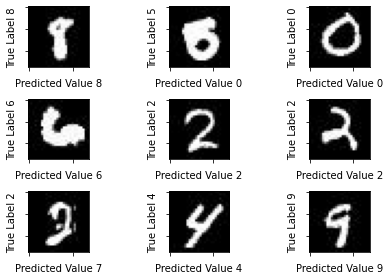

In [6]:
train(images_array,labels_array) 

In [7]:
model = models.load_model('cnn.h5') #load the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

In [48]:
def inference(filepath):
    image = cv2.imread(filepath) #read the image
    plt.imshow(image)
    image = np.expand_dims(image, axis=0) # expand the dimensions as model is waiting for batches of images
    image = np.vstack([image]) 
    model = models.load_model('cnn.h5') #load the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    prediction = model.predict_classes(image)
    print("Predicted Value = {}".format(int(prediction)))
    

    
    
    
    return prediction

Predicted Value = 7


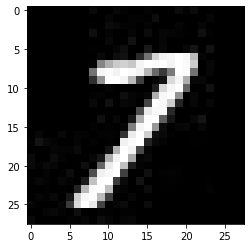

In [49]:
path = 'C:\\Users\\maria\\Documents\\pinky\\ASU\\Fall20\\Deep Learning\\Project\\trainingSet\\7\\img_117.jpg'
prediction = inference(path)